In [11]:
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 1
%aimport visualization.vis
%aimport utils.utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import pytorch_lightning as pl
import cv2
import matplotlib.pyplot as plt
import io

from torch_geometric.loader import DataLoader
from argparse import ArgumentParser
from datasets import ArgoverseV2Dataset
from predictors import QCNet
from predictors.autoval import AntoQCNet
from predictors.environment import WorldModel
from transforms import TargetBuilder
from av2.datasets.motion_forecasting import scenario_serialization
from av2.datasets.motion_forecasting.data_schema import (
    ArgoverseScenario,
    ObjectType,
    TrackCategory,
)
from av2.map.map_api import ArgoverseStaticMap
from pathlib import Path
from visualization.vis import plot_traj_with_data, plot_traj, vis_reward, generate_video
from utils.utils import get_transform_mat, get_auto_pred, add_new_agent, reward_function

pl.seed_everything(2023, workers=True)

parser = ArgumentParser()
parser.add_argument("--model", type=str, default="QCNet")
parser.add_argument("--root", type=str, default="/home/guanren/Multi-agent-competitive-environment/datasets")
parser.add_argument("--batch_size", type=int, default=1)
parser.add_argument("--num_workers", type=int, default=8)
parser.add_argument("--pin_memory", type=bool, default=True)
parser.add_argument("--persistent_workers", type=bool, default=True)
parser.add_argument("--accelerator", type=str, default="auto")
parser.add_argument("--devices", type=int, default=1)
parser.add_argument("--ckpt_path", default="checkpoints/epoch=10-step=274879.ckpt", type=str)
args = parser.parse_args("")

model = {
    "QCNet": AntoQCNet,
}[args.model].load_from_checkpoint(checkpoint_path=args.ckpt_path)
environment = {
    "QCNet": WorldModel,
}[args.model].load_from_checkpoint(checkpoint_path=args.ckpt_path)
val_dataset = {
    "argoverse_v2": ArgoverseV2Dataset,
}[model.dataset](
    root=args.root,
    split="val",
    transform=TargetBuilder(model.num_historical_steps, model.num_future_steps),
)


Global seed set to 2023
/home/guanren/anaconda3/envs/QCNet/lib/python3.8/site-packages/pytorch_lightning/utilities/migration/utils.py:51: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.1.1, which is newer than your current Lightning version: v2.0.4
  rank_zero_warn(


In [13]:
dataloader = DataLoader(
    val_dataset[[val_dataset.raw_file_names.index('0a8dd03b-02cf-4d7b-ae7f-c9e65ad3c900')]],
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=args.pin_memory,
    persistent_workers=args.persistent_workers,
)

trainer = pl.Trainer(accelerator=args.accelerator, devices=args.devices)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
it = iter(dataloader)
data = next(it)

/home/guanren/anaconda3/envs/QCNet/lib/python3.8/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


In [15]:
scenario_id = data["scenario_id"][0]
argoverse_scenario_dir = Path("/home/guanren/Multi-agent-competitive-environment/datasets/val/raw")

all_scenario_files = sorted(argoverse_scenario_dir.rglob(f"*_{scenario_id}.parquet"))
scenario_file_list = list(all_scenario_files)
scenario_path = scenario_file_list[0]
print(scenario_path)

static_map_path = scenario_path.parents[0] / f"log_map_archive_{scenario_id}.json"

scenario = scenario_serialization.load_argoverse_scenario_parquet(scenario_path)
scenario_static_map = ArgoverseStaticMap.from_json(static_map_path)

/home/guanren/Multi-agent-competitive-environment/datasets/val/raw/00a50e9f-63a1-4678-a4fe-c6109721ecba/scenario_00a50e9f-63a1-4678-a4fe-c6109721ecba.parquet


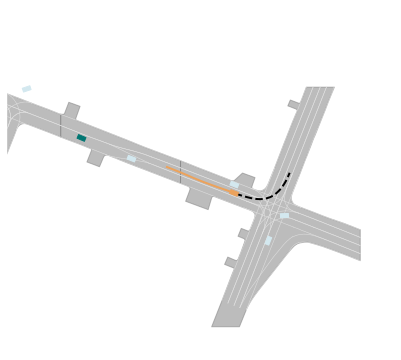

In [16]:
plot_traj(scenario_static_map,scenario)

In [17]:

for param in model.encoder.parameters():
        param.requires_grad = False
for param in model.decoder.parameters():
        param.requires_grad = False

from torch_geometric.data import Batch
from utils import wrap_angle
import torch, math
import copy
import numpy as np

if isinstance(data, Batch):
    data['agent']['av_index'] += data['agent']['ptr'][:-1]

tensor([[ 2656.3811, -2359.2805],
        [ 2656.9302, -2359.4792],
        [ 2657.4719, -2359.6741],
        [ 2658.0085, -2359.8652],
        [ 2658.5437, -2360.0552],
        [ 2659.0764, -2360.2412],
        [ 2659.6035, -2360.4248],
        [ 2660.1279, -2360.6072],
        [ 2660.6536, -2360.7881],
        [ 2661.1812, -2360.9685],
        [ 2661.7117, -2361.1489],
        [ 2662.2449, -2361.3315],
        [ 2662.7781, -2361.5166],
        [ 2663.3059, -2361.7034],
        [ 2663.8276, -2361.8901],
        [ 2664.3442, -2362.0754],
        [ 2664.8547, -2362.2607],
        [ 2665.3589, -2362.4468],
        [ 2665.8533, -2362.6306],
        [ 2666.3364, -2362.8105],
        [ 2666.8062, -2362.9834],
        [ 2667.2610, -2363.1482],
        [ 2667.7014, -2363.3074],
        [ 2668.1252, -2363.4597],
        [ 2668.5371, -2363.6067],
        [ 2668.9463, -2363.7495],
        [ 2669.3562, -2363.8879],
        [ 2669.7639, -2364.0227],
        [ 2670.1709, -2364.1550],
        [ 2670

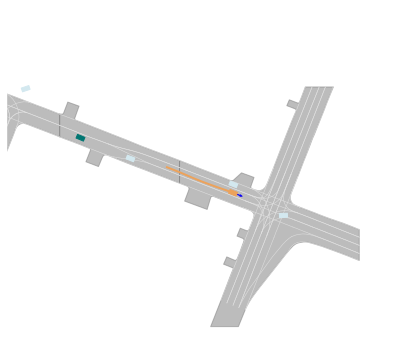

In [18]:
plot_traj_with_data(data,scenario_static_map,t=50)
agent_index = torch.nonzero(data['agent']['category']==3,as_tuple=False).item()
print(data['agent']['position'][agent_index,30:,:2])
print(data['agent']['heading'][agent_index,:])

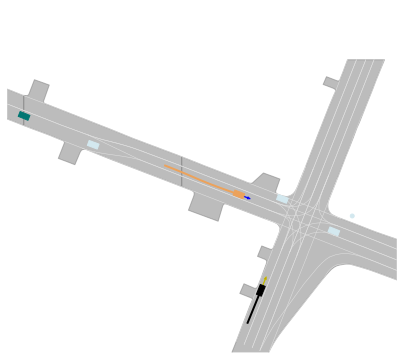

In [19]:


new_input_data=add_new_agent(data)
# new_input_data=data.clone()
# init_origin,init_theta,init_rot_mat=get_transform_mat(new_input_data,model)
plot_traj_with_data(new_input_data,scenario_static_map,bounds=60,t=40)

# new_input_data['agent']['valid_mask'][:]=False
# new_input_data['agent']['valid_mask'][new_input_data["agent"]["category"] == 3] = True
# new_input_data['agent']['valid_mask'][new_input_data["agent"]["category"] == 2] = True
# new_input_data['agent']['valid_mask'][2] = True

In [35]:
vid_path = "test.webm"
generate_video(new_input_data,scenario_static_map, model, vid_path)

OpenCV: FFMPEG: tag 0x30385056/'VP80' is not supported with codec id 139 and format 'webm / WebM'


/tmp/ipykernel_269589/1622738850.py:243: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  vehicle_bounding_box = Rectangle(


IndexError: The shape of the mask [29] at index 0 does not match the shape of the indexed tensor [30, 6, 60, 4] at index 0

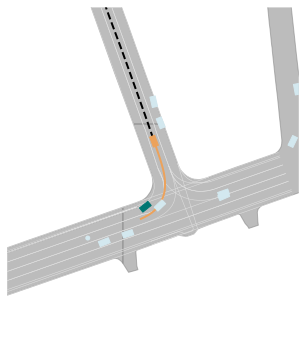

In [ ]:
plot_traj(50.0)
for i in range(6):
    xy = true_traj_refine[[data["agent"]["category"] == 2]][0].cpu().detach()
    plt.plot(xy[i, ..., 0], xy[i, ..., 1])
# for i in range(6):
#     xy = new_position[1][data["agent"]["category"] == 3][0].cpu().detach()
#     plt.plot(xy[i, ..., 0], xy[i, ..., 1])


In [ ]:
[x.value for x in _STATIC_OBJECT_TYPES]

In [ ]:
import math
data['agent']['position'][data['agent']['category']==3][0,45]
print(data['agent']['category']==3)
print(torch.nonzero(data['agent']['category']==3,as_tuple=False).item())

In [60]:
import torch

def sample_from_pdf(pdf, num_samples):
    # 将概率密度函数转换为概率分布
    pdf_distribution = torch.softmax(pdf, dim=-1)
    
    # 进行采样
    sampled_values = torch.multinomial(pdf_distribution, num_samples=num_samples)
    
    return sampled_values.tolist()

# 给定的概率密度函数
pdf = torch.tensor([[0.0084, 0.1141, 0.0408, 0.2374, 0.2296, 0.3697]], device='cuda:0')

# 采样30个值
sampled_values = sample_from_pdf(pdf, num_samples=30)

print(sampled_values)



RuntimeError: cannot sample n_sample > prob_dist.size(-1) samples without replacement

In [ ]:
vid_path = "test2.webm"
generate_video(new_input_data,scenario_static_map, model, vid_path)

torch.Size([1, 6])
tensor([[0.0084, 0.1141, 0.0408, 0.2374, 0.2296, 0.3697]], device='cuda:0')


OpenCV: FFMPEG: tag 0x30385056/'VP80' is not supported with codec id 139 and format 'webm / WebM'


In [ ]:
vid_path = "test2.webm"
generate_video(new_input_data,scenario_static_map, model, vid_path)

torch.Size([1, 6])
tensor([[0.0084, 0.1141, 0.0408, 0.2374, 0.2296, 0.3697]], device='cuda:0')


OpenCV: FFMPEG: tag 0x30385056/'VP80' is not supported with codec id 139 and format 'webm / WebM'


In [ ]:
vid_path = "test2.webm"
generate_video(new_input_data,scenario_static_map, model, vid_path)

torch.Size([1, 6])
tensor([[0.0084, 0.1141, 0.0408, 0.2374, 0.2296, 0.3697]], device='cuda:0')


OpenCV: FFMPEG: tag 0x30385056/'VP80' is not supported with codec id 139 and format 'webm / WebM'
